# Question-answering multiple choice questions

Firts, let's download a public MMLU [dataset](https://huggingface.co/datasets/cais/mmlu) from HuggingFace:

In [ ]:
from datasets import load_dataset
ds = load_dataset("cais/mmlu", "high_school_geography")

test-00000-of-00001.parquet:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/198 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

We can explore the dataset:

In [ ]:
ds_dict = ds["test"].take(100).to_dict()
print(ds_dict["question"][0])

The main factor preventing subsistence economies from advancing economically is the lack of


In [ ]:
print(ds_dict["choices"][0])

['a currency.', 'a well-connected transportation infrastructure.', 'government activity.', 'a banking service.']


In [ ]:
ds_dict["answers"][0]["aliases"][0]

['Washington D.C.',
 'Washington',
 'The District',
 'U.S. Capital',
 'District of Columbia / Washington city',
 'The District of Columbia',
 'District of Columbia',
 'Washington DC']

Now, let's create our research agent (pay attention to how we put together the system prompt by describing the agent's profile!):

In [ ]:
llm_small = ChatVertexAI(model="gemini-1.5-flash-002", temperature=1.0)

In [ ]:
from langchain.agents import load_tools
from langgraph.prebuilt import create_react_agent


research_tools = load_tools(
  tool_names=["ddg-search", "arxiv", "wikipedia"],
  llm=llm
)

system_prompt = (
    "You're a hard-working, curious and creative student. "
    "You're working on exam quesion. Think step by step."
    "Always provide an argumentation for your answer. "
    "Do not assume anything, use available tools to search "
    "for evidence and supporting statements."
)


In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import MessagesState
from langgraph.prebuilt.chat_agent_executor import AgentState

raw_prompt_template = (
    "Answer the following multiple-choice question. "
    "\nQUESTION:\n{question}\n\nANSWER OPTIONS:\n{options}\n"
)
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt),
     ("user", raw_prompt_template),
     ("placeholder", "{messages}")
     ]
)

class ResearchState(AgentState):
  question: str
  options: str

research_agent = create_react_agent(model=llm_small, tools=research_tools, state_schema=ResearchState, prompt=prompt)

Now we define another agent that reflects on the anwer and provides critique:

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate


raw_prompt_template_with_critique = (
    "You tried to answer the exam question and you get feedback from your "
    "professor. Work on improving your answer and incorporating the feedback. "
    "\nQUESTION:\n{question}\n\nANSWER OPTIONS:\n{options}\n\n"
    "INITIAL ANSWER:\n{answer}\n\nFEEDBACK:\n{feedback}"

)
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt),
     ("user", raw_prompt_template_with_critique),
     ("placeholder", "{messages}")
     ]
)

class ReflectionState(ResearchState):
  answer: str
  feedback: str

research_agent_with_critique = create_react_agent(model=llm_small, tools=research_tools, state_schema=ReflectionState, prompt=prompt)

In [ ]:
reflection_prompt = (
    "You are a university professor and you're supervising a student who is "
    "working on multiple-choice exam question. "
    "nQUESTION: {question}.\nANSWER OPTIONS:\n{options}\n."
    "STUDENT'S ANSWER:\n{answer}\n"
    "Reflect on the answer and provide a feedback whether the answer "
    "is right or wrong. If you think the final answer is correct, reply with "
    "the final answer. Only provide critique if you think the asnwer might "
    "be incorrect or there are reasoning flaws. Do not assume anything, "
    "evaluate only the reasoning the student provided and whether there is "
    "enough evidence for their answer."
)

class Response(BaseModel):
    """A final response to the user."""

    answer: Optional[str] = Field(
        description="The final answer. It should be empty if critique has been provided.",
        default=None,
    )
    critique: Optional[str] = Field(
        description="A critique of the initial answer. If you think it might be incorrect, provide an acitonable feedback",
        default=None,
    )


Let's put everything together and create a multi-agent system:

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.runnables.config import RunnableConfig
from operator import add
from langchain_core.output_parsers import StrOutputParser

class ReflectionAgentState(TypedDict):
    question: str
    options: str
    answer: str
    steps: Annotated[int, add]
    response: Response


def _should_end(state: AgentState, config: RunnableConfig) -> Literal["research", END]:
    max_reasoning_steps = config["configurable"].get("max_reasoning_steps", 10)
    if state.get("response") and state["response"].answer:
        return END
    if state.get("steps", 1) > max_reasoning_steps:
        return END
    return "research"

reflection_chain = PromptTemplate.from_template(reflection_prompt) | llm.with_structured_output(Response)

def _reflection_step(state):
    result = reflection_chain.invoke(state)
    return {"response": result, "steps": 1}


def _research_start(state):
  answer = research_agent.invoke(state)
  return {"answer": answer["messages"][-1].content}


def _research(state):
  agent_state = {
      "answer": state["answer"],
      "question": state["question"],
      "options": state["options"],
      "feedback": state["response"].critique
  }
  answer = research_agent_with_critique.invoke(agent_state)
  return {"answer": answer["messages"][-1].content}

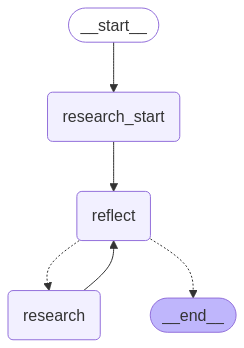

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(ReflectionAgentState)
builder.add_node("research_start", _research_start)
builder.add_node("research", _research)
builder.add_node("reflect", _reflection_step)

builder.add_edge(START, "research_start")
builder.add_edge("research_start", "reflect")
builder.add_edge("research", "reflect")
builder.add_conditional_edges("reflect", _should_end)
graph = builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take a random question and run our agent:

In [ ]:
i = 3
question = ds_dict["question"][i]
options = "\n".join([f"{i}. {a}" for i, a in enumerate(ds_dict["choices"][i])])

async for _, event in graph.astream({"question": question, "options": options}, stream_mode=["updates"]):
  print(event)

{'research_start': {'answer': "The correct answer is **3. Fourth**.\n\nHere's why:\n\nBurgess's concentric zone model depicts a city as a series of concentric rings.  The fourth zone, located on the periphery of the city, is characterized by low-income slums, ethnic ghettos, and general deterioration.  This is because this zone is typically the furthest from the city center, less desirable, and therefore occupied by those with fewer resources. The other zones represent different stages of urban development and socioeconomic status.\n"}}
{'reflect': {'response': Response(answer=None, critique="The student's answer is incorrect. The zone characterized by low-income slums, ethnic ghettos, and general deterioration in Burgess's concentric zone model is the Zone of Transition, which is the second zone. The student incorrectly identified the fourth zone as having these characteristics. The fourth zone is typically a residential zone of higher-quality housing."), 'steps': 1}}
{'research': {'a